# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
import os

## Format & Preprocess Data

In [2]:
df = pd.read_csv("./AffectNet Dataset/labels.csv")

In [127]:
df

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108
...,...,...,...,...
28170,28170,surprise/image0034960.jpg,surprise,0.825263
28171,28171,surprise/image0034961.jpg,surprise,0.738646
28172,28172,surprise/image0034966.jpg,surprise,0.774524
28173,28173,surprise/image0034973.jpg,neutral,0.766952


In [26]:
df['label'].unique()

array(['surprise', 'anger', 'disgust', 'fear', 'sad', 'contempt',
       'neutral', 'happy'], dtype=object)

In [122]:
def getFileExtension(sentiment):
    if sentiment in jpgList:
        return "jpg"
    if sentiment in pngList:
        return "png"

jpgList = ['anger','fear','sad']
pngList = ['contempt','disgust','happy','neutral','surprise']

labelMap = {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}
intToLabelMap = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'}

imageRootPath = "./AffectNet Dataset/"
imageFilePath = "happy/ffhq_34.png"
imagePath = imageRootPath + imageFilePath

image = Image.open(imagePath).convert("RGB")
image

transform = transforms.Compose([
    transforms.Resize((256)),
    transforms.CenterCrop((224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

imageTensor = transform(image)
imageTensor = imageTensor.unsqueeze(0)

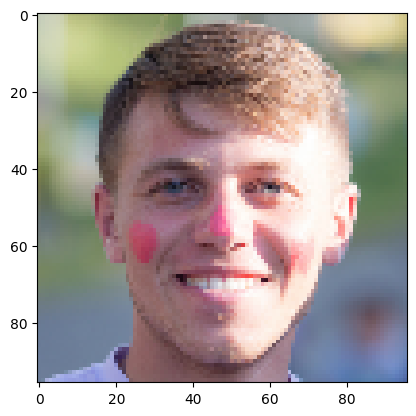

In [5]:
plt.imshow(image)

## Dataset

In [6]:
from torch.utils.data import Dataset, DataLoader

        # Library has entires in the form of tuples
        # Each tuple has the image path at the 0th index
        # and the label at the 1st

class FacialSentimentDataset(Dataset):
    def __init__(self, path, labelMap, transform):
        self.path = path
        self.images = []
        self.labels = []
        self.labelMap = labelMap
        self.transform = transform

        # Populate library with image paths and corresponding labels
        # Get each folder in the dataset
        for folder in os.listdir(path):
            # Skip labels file
            if folder == "labels.csv":
                continue
            # Get each image in each folder
            for image in os.listdir(path + folder):
                # Get image's corresponding label
                try:
                    label = df[df['pth'] ==  folder + '/' + image]['label'].item()
                    # self.library.append((folder + '/' + image,label))
                    self.images.append(folder + '/' + image)
                    self.labels.append(label)
                # Skip images that are not labeled
                except ValueError as e:
                    continue
        
    # Add get dataset's length function
    def __len__(self):
        return len(self.images)

    # Add get item at index from dataset
    def __getitem__(self,idx):
        # Get image path from library at an index
        imagePath = self.images[idx]
        # Open image with PIL
        image = Image.open(self.path + imagePath).convert("RGB")
        # Get label path from library at an index
        label = self.labels[idx]
        label = self.labelMap[label]

        # Apply given transform to each image
        if self.transform:
            image = self.transform(image)

        return image,label


dataset = FacialSentimentDataset("./AffectNet Dataset/", labelMap, transform)

## Set Up Model

Load pre-trained ResNet & Libraries

In [90]:
import torchvision.models as models
import pytorch_lightning as pl
from torchmetrics import Accuracy

# Load ResNet
resnet50 = models.resnet50(pretrained=True)

In [98]:
class FacialSentimentAnalyser(pl.LightningModule):
    def __init__(self, num_classes):
        super(FacialSentimentAnalyser,self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.learning_rate = 0.001
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(num_classes=len(labelMap), task="multiclass", average='macro').to("cuda")


    def forward(self, x):
        return self.resnet(x)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batchIdx):
        image, label = batch
        logits = self(image)
        loss = self.loss(logits, label)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds,label)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batchIdx):
        image, label = batch
        logits = self(image)
        loss = self.loss(logits, label)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds,label)
        self.log('validation_loss', loss, prog_bar=True)
        self.log('validation_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batchIdx):
        image, label = batch
        logits = self(image)
        loss = self.loss(logits, label)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds,label)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

## Train

Split Dataset

In [99]:
trainDatasetSize = int(0.7*len(dataset))
validationDatasetSize = int(0.2*len(dataset))
testDatasetSize = len(dataset) - (trainDatasetSize + validationDatasetSize)

from torch.utils.data import random_split

trainDataset, validationDataset, testDataset = random_split(dataset, [trainDatasetSize, validationDatasetSize, testDatasetSize])

Set Up Dataloaders

In [100]:
trainDataloader = DataLoader(trainDataset, batch_size=32, shuffle=True)
validationDataloader = DataLoader(validationDataset, batch_size=32, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=32, shuffle=True)

In [101]:
from pytorch_lightning import Trainer
numEpochs = 15

model = FacialSentimentAnalyser(len(labelMap))

trainer = Trainer(accelerator="gpu", devices="auto", max_epochs=numEpochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [102]:
trainer.fit(model, trainDataloader, validationDataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 23.5 M
1 | loss     | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.098    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\mekae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [103]:
# After training is completed
metrics = trainer.logged_metrics
print(metrics)


{'train_loss_step': tensor(0.1400), 'train_acc_step': tensor(0.6667), 'validation_loss': tensor(1.5856), 'validation_acc': tensor(0.6321), 'train_loss_epoch': tensor(0.1214), 'train_acc_epoch': tensor(0.9554)}


## Test

In [107]:
trainer.test(model,testDataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\mekae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\mekae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6330384612083435
        test_loss           1.5516921281814575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5516921281814575, 'test_acc': 0.6330384612083435}]

## Inference

In [144]:
model.eval()

imageRootPath = "./AffectNet Dataset/"
imageFilePath = "happy/ffhq_31.png"
image = Image.open(imageRootPath + imageFilePath)
image = transform(image).unsqueeze(0)
logits = model(image)
predictions = torch.argmax(logits, dim=1)

res = intToLabelMap[predictions.item()]
expected = df[df["pth"] == imageFilePath]['label'].item()
print(res)
print(expected)

res == expected


disgust
disgust


True